(from README.md)
### Overview

**Consumers** includes images of retail consumers captured from RGB cameras and their ground truth bounding-box locations.

**BID** comprises cropped full-body images of annotated consumers with their ground truth age-range and gender information.

Both datasets are anonymized following the *privacy-by-design* principle, and their use is intended for various computer vision tasks. However, it is not limited to these tasks. Please refer to the sections below for important information regarding the use of this dataset.

This version  only includes the **evaluation** (test) set partitions. We will soon upload the training partitions as well.

### Structure

- **Consumers** includes 145 video sequences split into 120 training and 25 testing partitions featuring 8700 images/frames in total. The structure of the dataset is as follows:

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F17922636%2F064ee2e51239f2c5b0a5e38685689be4%2FConsumersSmall.png?generation=1701373217319160&alt=media)

where *gt.txt* includes the holistic annotation information [frame_id, consumer_id, bounding-box] for the entire sequence, readily available for evaluating the tracking algorithm (i.e., compatible with MOT challenge format). Each frameID.txt contains annotation information [consumer_ID bounding_box_coords(center point, box width, and height) age_group gender] per annotated instance in the frame.

- **BID** (body image dataset) comrpises 6641 cropped images from each *Consumers* sequence, split into 5507 training images and 1134 images for testing. The structure of the dataset is as follows:

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F17922636%2Fadb4074045b5abc61903eacb8ecbbe1f%2FBIDStructureSmall.png?generation=1701373230351014&alt=media)
  
- We consider four age groups: (1) below 12–20 years, (2) 21–36, (3) 37–60, and (4) over 61,
and each cropped body image corresponds to a single instance of a target consumer, which is also reflected by the image name (frameID_consumerID)
- Annotations are provided within *index.txt* in the format: [GENDER AGE_GROUP_1 AGE_GROUP_2 AGE_GROUP_3 AGE_GROUP_4]. For example, the 1 hot representation [1 0 1 0 0] denotes a consumer instance of a female in the 21 to 36 age group.

## Code

In [ ]:
!pip install kagglehub

In [ ]:
!pip install matplotlib

In [ ]:

!pip install torch torchvision albumentations

In [ ]:
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
import csv

import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, ToTensor

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Subset
import random

import kagglehub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("angelosgiotis/consumers-bid")

print("Path to dataset files:", path)

In [7]:
class ConsumersGTDataset(Dataset):
    """
    Dataset for Consumers sequences where each sequence folder contains images and a `gt/gt.txt`.
    Root structure:
      root/
        Sequence_ID000/
          img_00001.jpg
          img_00002.jpg
          gt/
            gt.txt
        Sequence_ID001/
          ...
        gt.txt format (no header), each line:
            photo_id, consumer_id, x_top_left, y_top_left, width, height
        Coordinates are assumed to be top-left corner (x, y, width, height).
        photo_id may include extension or be just frame id.
    """

    def __init__(self, root, sequences=None, transform=None,
                 img_extensions=('.jpg', '.jpeg', '.png'), try_find=True):
        self.root = Path(root)
        if not self.root.exists():
            raise FileNotFoundError(f"Root path does not exist: {self.root}")
        self.transform = transform
        self.img_extensions = tuple(e.lower() for e in img_extensions)
        self.try_find = try_find

        # list sequences (directories) to scan
        if sequences is None:
            sequences = sorted([p.name for p in self.root.iterdir() if p.is_dir()])
        self.sequences = sequences

        # mapping image_path -> list of anns
        self._anns = {}  # Path -> list of (consumer_id, cx, cy, w, h, normalized_flag_guess)
        for seq in self.sequences:
            seq_dir = self.root / seq
            if not seq_dir.exists() or not seq_dir.is_dir():
                continue
            gt_path = seq_dir / 'gt' / 'gt.txt'
            if not gt_path.exists():
                # skip sequences without gt
                continue
            # parse gt file
            with open(gt_path, 'r', encoding='utf-8') as f:
                first = f.readline()
                # decide delimiter
                if ',' in first:
                    delimiter = ','
                else:
                    delimiter = None
                # re-open to iterate from start
            with open(gt_path, 'r', encoding='utf-8') as f:
                if delimiter:
                    reader = csv.reader(f, delimiter=delimiter)
                else:
                    reader = csv.reader(f, delimiter=None, skipinitialspace=True)
                for row in reader:
                    if not row:
                        continue
                    # normalize and filter blank parts
                    row = [r.strip() for r in row if r is not None and str(r).strip() != '']
                    if len(row) < 6:
                        continue
                    photo_id_raw = row[0]
                    try:
                        consumer_id = int(row[1])
                        x_tl = float(row[2])
                        y_tl = float(row[3])
                        w_box = float(row[4])
                        h_box = float(row[5])
                    except Exception:
                        continue

                    # resolve image path inside this sequence
                    img_path = self._resolve_image_path(seq_dir, photo_id_raw)
                    if img_path is None:
                        # not found; optionally try slower search inside seq_dir
                        if self.try_find:
                            img_path = self._fuzzy_find(seq_dir, photo_id_raw)
                    if img_path is None:
                        # skip annotations without image match
                        continue

                    # guess whether coordinates are normalized (0..1)
                    normalized_guess = (0.0 <= x_tl <= 1.0 and 0.0 <= y_tl <= 1.0 and 0.0 <= w_box <= 1.0 and 0.0 <= h_box <= 1.0)

                    key = str(img_path.resolve())
                    self._anns.setdefault(key, []).append((consumer_id, x_tl, y_tl, w_box, h_box, normalized_guess))

        # Build items: include all image files in the scanned sequences
        # even if they have no annotations (we'll return empty targets for those)
        items = []
        for seq in self.sequences:
            seq_dir = self.root / seq
            if not seq_dir.exists() or not seq_dir.is_dir():
                continue
            for p in sorted(seq_dir.iterdir()):
                if p.is_file() and p.suffix.lower() in self.img_extensions:
                    items.append(p)
        # keep only those images that are within the sequences we scanned
        # final items stored as resolved Paths
        self.items = [p.resolve() if isinstance(p, Path) else Path(p).resolve() for p in items]

    def _resolve_image_path(self, seq_dir: Path, photo_id_raw: str):
        """
        Try direct resolution: seq_dir / photo_id_raw, or append extensions if missing.
        Returns Path or None.
        """
        pid = photo_id_raw
        p = seq_dir / pid
        if p.exists() and p.is_file():
            return p
        # if pid contains subdirs, try relative path
        p = seq_dir / pid
        if p.exists() and p.is_file():
            return p
        # try with extensions
        if not Path(pid).suffix:
            for ext in self.img_extensions:
                candidate = seq_dir / (pid + ext)
                if candidate.exists():
                    return candidate
        # sometimes photo_id includes a sequence prefix; try only filename
        name = Path(pid).name
        p = seq_dir / name
        if p.exists():
            return p
        return None

    def _fuzzy_find(self, seq_dir: Path, photo_id_raw: str):
        """
        Slower fallback: search files in seq_dir for filename containing photo_id_raw.
        """
        pid = photo_id_raw.lower()
        for p in seq_dir.rglob('*'):
            if p.is_file() and p.suffix.lower() in self.img_extensions:
                if pid in p.name.lower():
                    return p
        return None

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path = self.items[idx]
        ann_list = self._anns.get(str(img_path.resolve()), [])
        img = Image.open(img_path).convert('RGB')
        w_img, h_img = img.size

        boxes = []
        ids = []
        for (cid, x_tl, y_tl, w_box, h_box, normalized_guess) in ann_list:
            if normalized_guess:
                # normalized top-left coordinates -> convert to pixels
                x_px = x_tl * w_img
                y_px = y_tl * h_img
                w_px = w_box * w_img
                h_px = h_box * h_img
            else:
                x_px, y_px, w_px, h_px = x_tl, y_tl, w_box, h_box

            # top-left (x_px,y_px,w_px,h_px) -> x1,y1,x2,y2
            x1 = x_px
            y1 = y_px
            x2 = x_px + w_px
            y2 = y_px + h_px

            # clip
            x1 = max(0.0, x1)
            y1 = max(0.0, y1)
            x2 = min(float(w_img), x2)
            y2 = min(float(h_img), y2)

            if x2 <= x1 or y2 <= y1:
                continue

            boxes.append([x1, y1, x2, y2])
            ids.append(int(cid))

        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            ids = torch.tensor(ids, dtype=torch.long)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            ids = torch.tensor([], dtype=torch.long)

        target = {
            'boxes': boxes,
            'ids': ids,
            'image_id': torch.tensor([idx]),
            'file_path': str(img_path)
        }

        if self.transform is not None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        return img, target


def collate_detection(batch):
    """
    Collate that returns images (stacked if same shape) and list of target dicts.
    """
    images = [b[0] for b in batch]
    targets = [b[1] for b in batch]
    # Try stacking — will raise if shapes differ
    try:
        images = torch.stack(images, dim=0)
    except Exception:
        # keep list of tensors
        pass
    return images, targets

Shown image 0 with 1 boxes


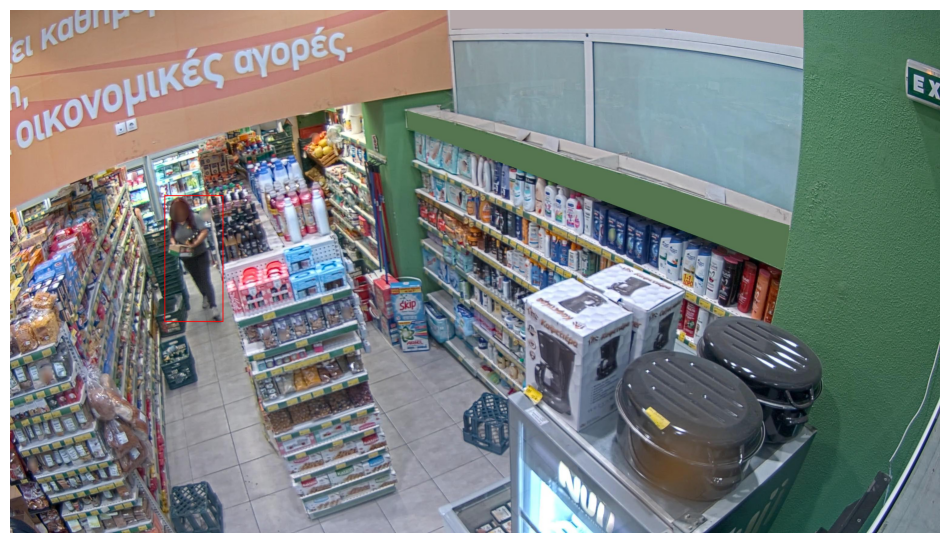

In [9]:
# Пример: создать датасет и визуализировать боксы для произвольного индекса

# Трансформы — по желанию (визуализация использует исходный файл для точных координат)
val_transform = transforms.Compose([
    transforms.Resize((480, 854)),   # опционально
    transforms.ToTensor()
])

# Если вы использовали kagglehub выше, переменная `path` указывает на распакованный датасет.
# Настройте root на реальную папку с Sequence_* каталогами. Например: Path(path)/'Consumers'
from pathlib import Path
dataset_root = Path(path) / 'Consumers' if 'path' in globals() else Path('path/to/dataset_root')
dataset = ConsumersGTDataset(root=dataset_root, transform=val_transform)

def visualize_idx(dataset, idx, figsize=(12,8), show=True):
    img_tensor, target = dataset[idx]
    fp = target.get('file_path', None)
    # Open original image when available to draw in pixel coords
    if fp is not None and Path(fp).exists():
        pil_img = Image.open(fp).convert('RGB')
    else:
        pil_img = ToPILImage()(img_tensor)

    draw = ImageDraw.Draw(pil_img)
    boxes = target.get('boxes')
    ids = target.get('ids')
    if boxes is not None and boxes.numel() > 0:
        boxes_np = boxes.detach().cpu().numpy()
        ids_np = ids.detach().cpu().numpy() if ids is not None and ids.numel() > 0 else [None]*len(boxes_np)
        for b, cid in zip(boxes_np, ids_np):
            x1,y1,x2,y2 = b
            draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
            label = str(int(cid)) if cid is not None else ''
            # label background
            text_pos = (max(0, x1), max(0, y1-12))
            draw.text(text_pos, label, fill='yellow')
    if show:
        plt.figure(figsize=figsize)
        plt.imshow(pil_img)
        plt.axis('off')
    return pil_img, target

# Визуализируем первый элемент (или укажите другой индекс)
if len(dataset) == 0:
    print('Dataset is empty — проверьте путь `dataset_root` и наличие gt/gt.txt в sequence папках')
else:
    pil_img, target = visualize_idx(dataset, 350)
    print('Shown image 0 with', target.get('boxes').shape[0], 'boxes')

In [ ]:
# Augmentation + train/val split using existing ConsumersGTDataset (no new Dataset class)

# Define bbox-aware albumentations transforms (expects bboxes in pascal_voc: [x1,y1,x2,y2])
train_alb = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Resize(480, 854)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_alb = A.Compose([
    A.Resize(480, 854)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# collate factory that applies albumentations per-sample using original file_path from target
def make_collate(alb_transform):
    to_tensor = ToTensor()
    def collate_fn(batch):
        images_out = []
        targets_out = []
        for img_tensor, target in batch:
            fp = target.get('file_path', None)
            boxes = target.get('boxes')
            ids = target.get('ids')
            if boxes is None or boxes.numel() == 0:
                bboxes = []
                labels = []
            else:
                bboxes = boxes.detach().cpu().numpy().tolist()
                labels = ids.detach().cpu().numpy().tolist()

            if fp is not None and Path(fp).exists():
                # open original image (PIL) to apply albumentations in pixel coords
                pil = Image.open(fp).convert('RGB')
                img_np = np.array(pil)
                try:
                    aug = alb_transform(image=img_np, bboxes=bboxes, labels=labels)
                    img_np = aug['image']
                    bboxes = aug.get('bboxes', [])
                    labels = aug.get('labels', [])
                except Exception:
                    # if augmentation fails (e.g., wrong bbox format), fallback to original
                    img_np = np.array(pil)
            else:
                # No file path: try to use provided tensor (already transformed) — convert to PIL then to numpy
                try:
                    pil = ToPILImage()(img_tensor)
                    img_np = np.array(pil)
                    aug = alb_transform(image=img_np, bboxes=bboxes, labels=labels) if alb_transform is not None else {'image':img_np,'bboxes':bboxes,'labels':labels}
                    img_np = aug['image']
                    bboxes = aug.get('bboxes', [])
                    labels = aug.get('labels', [])
                except Exception:
                    # fallback: convert tensor directly
                    img_np = img_tensor.detach().cpu().numpy().transpose(1,2,0)

            # convert to tensor
            img_t = to_tensor(img_np)
            images_out.append(img_t)

            if bboxes:
                boxes_t = torch.tensor(bboxes, dtype=torch.float32)
                ids_t = torch.tensor(labels, dtype=torch.long)
            else:
                boxes_t = torch.zeros((0,4), dtype=torch.float32)
                ids_t = torch.tensor([], dtype=torch.long)

            new_target = {'boxes': boxes_t, 'ids': ids_t, 'image_id': target.get('image_id', torch.tensor([-1])), 'file_path': target.get('file_path')}
            targets_out.append(new_target)

        # try stacking images (may fail if shapes differ)
        try:
            images_out = torch.stack(images_out, dim=0)
        except Exception:
            pass
        return images_out, targets_out
    return collate_fn

# Split indices helper
def split_indices(dataset, val_ratio=0.2, seed=42):
    n = len(dataset)
    idx = list(range(n))
    rnd = random.Random(seed)
    rnd.shuffle(idx)
    split = int(n*(1-val_ratio))
    return idx[:split], idx[split:]

# Build base dataset (no transform here; collate will handle resizing/augmentation)
base_ds = ConsumersGTDataset(root=dataset_root, transform=None)
train_idx, val_idx = split_indices(base_ds, val_ratio=0.2, seed=42)
train_base = Subset(base_ds, train_idx)
val_base = Subset(base_ds, val_idx)

train_loader = DataLoader(train_base, batch_size=16, shuffle=True, num_workers=4, collate_fn=make_collate(train_alb), pin_memory=True)
val_loader = DataLoader(val_base, batch_size=8, shuffle=False, num_workers=4, collate_fn=make_collate(val_alb), pin_memory=True)

print('Sizes — all:', len(base_ds), 'train:', len(train_base), 'val:', len(val_base))

Кратко и просто:

- Есть `train_loader` и `val_loader` для обучения и валидации.
- Используется `ConsumersGTDataset` для загрузки изображений и bbox.
- Для аугментаций есть трансформации и collate-функция (`make_collate`).
- Функция `visualize_idx(dataset, idx)` показывает изображение с нарисованными bounding-box и id.


Готово — можно запускать обучение или посмотреть примеры батча/визуализации.